# Tutorial 3: Canonical Equation of Adaptive Dynamics

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from functools import partial
from scipy.misc import derivative
import matplotlib.cm
%matplotlib inline

# Canonical equation

The canonical equation of adaptive dynamics is an ODE describing the dynamics of the mean distribution of a trait value $u$:

\begin{equation}
\frac{du}{dt} = \mu(u) \frac{\sigma(u)^2}{2} n(u) \frac{\partial s_u(m))}{\partial m} \Big |_{m=u}
\end{equation}

Where: 
   - $\mu(u)$ is the mutation probability for an individual with trait $u$,
   - $\sigma(u)$ the trait variance of mutants spawned from individuals with trait $u$,
   - $n(u)$ is the population size when the mean trait value is $u$,
   - $s_r(m)$ is the invasion fitness of an individual with trait $m$ in a resident population with trait $r$. 
   
We will numerically integrate this ODE with [`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). 

This function will return the trajectory of a system: 

\begin{equation}
\{y(t), t \in \mathbb t \}
\end{equation}

By performing: 

\begin{equation}
y(t) = y(0) + \int_0^t y'(y(x), x) dx
\end{equation}


[`scipy.integrate.odeint`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) has three required arguments:

   - `func`: $y'(y(t),t)$, computes the derivative of y at t. 
   - `y0`: $y_0$, initial conditions on y
   - `t`: $\mathbb t$, a sequence of points on which to return the trajectory. 

Let us build this function:

\begin{equation}
f(y(t), t) = \frac{du}{dt}(u(t),t)
\end{equation}

In [2]:
def canonical_equation(u, t, n, fitness_gradient, mu, sigma):
    """ODE describing the dynamics of s, the mean of the distribution of the trait value. 
    
    Args:
        u: (float) mean of the distribution of the trait value,
        t: (float) time (ignored, this ODE is autonomous, but required by the integrator),
        n: (function of u) population size,
        fitness_gradient (function of u): ds(m=u,r=u) derivative of the invasion fitness,
        mu (function of u): mutation probability,
        sigma (function of u): Variance of the distribution of a mutant trait m.
    Returns: du/dt (u, t)
    
    From Champagnat et al. 2002"""
    return mu(u) * sigma(u)**2/2  * n(u) * fitness_gradient(u)


def fitness_gradient(u, inv_fitness):
    """Compute the gradient of the invasion fitness with respect to its first variable. 
    Args:
        u (float): trait value.
        inv_fitness (function): Invasion fitness s(m,r) of a mutant m in a population set by a resident r.
    Return:
        ds(m, r) / dm  evaluated in m=u, r=u. 
    """
    return derivative(partial(inv_fitness,r=u),x0=u)

# Model
This is an extract from the tutorial 01.

In [11]:
p_common = { "b2":0, 'd1':2,'d2':2,'K1':1,'K2':1,'mu':0.1}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

def A(u, a, b):
    """Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate."""
    return a + b * u 

def F1_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return (d*K)/(A(u1, a, b)*u1*N1 + A(u2, a, b)*u2*N2 + d)

def F2_QSS(d, K, a, b, u1, N1, u2, N2):
    """Quasi-Steady state approximation of the density of prey in env 2."""
    return (d*K)/(A(u1, a, b)*(1-u1)*N1 + A(u2, a, b)*(1-u2)*N2 + d)
                 
def beta(u, F1, F2, a1, b1, a2, b2):
    """Birth rate of a predator with trait u"""
    return (  F1 * A(u, a1, b1) * u 
            + F2 * A(u, a2, b2) * (1-u)) 
            
def growth_rate(N1, N2, u1, u2, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Per capita growth rate of predator species N1 when the prey is at QSS"""
    F1 = F1_QSS(d1, K1, a1, b1, u1, N1, u2, N2)
    F2 = F2_QSS(d2, K2, a2, b2, u1, N1, u2, N2)
    return beta(u1, F1, F2, a1, b1, a2, b2) - mu

def n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    # Rough estimate used to initialise the optimisation algorithm.
    estimate = (d1*K1+d2*K2)/mu
    
    # We fix the value of the other parameters before solving for N1.
    resident_growth_rate = partial(growth_rate,
                                   u1 = r,
                                   N2=0, u2=0,
                                   a1=a1, a2=a2, 
                                   b1=b1, b2=b2, 
                                   d1=d1, d2=d2,
                                   K1=K1, K2=K2, 
                                   mu=mu)
    return scipy.optimize.fsolve(resident_growth_rate,x0=estimate)

def invasion_fitness(m, r, a1, a2, b1, b2, d1, d2, K1, K2, mu):
    """Invasion fitness of a rare mutant type with trait m in a resident population
    with trait r"""
    
    # Conpute the ecological equilibrium of the resident.
    Nstar = n_star(r, a1, a2, b1, b2, K1, K2, d1, d2, mu)
    
    # Invasion fitness is the growth rate of a rare mutant (N=0, u=m)
    # in a resident population at equilibrium (N=Nstar, u=r)
    return growth_rate(N1=0, N2=Nstar, u1=m, u2=r, 
                       a1=a1, a2=a2, b1=b1, b2=b2, K1=K1, 
                       K2=K2, d1=d1, d2=d2, mu=mu)

# Simulations

In [5]:
##### Here we prepare the model. #####

# The population size as a function of the trait value is given by our nstar approximation.
N = partial(n_star, **p_strong)

# The invasion fitness is given by the growth rate of the mutant.
s = partial(invasion_fitness, **p_strong)

# The fitness gradient is computed 
ds = partial(fitness_gradient, inv_fitness=s)

# we take constant mutation rate and variance
mu = lambda u:1
sigma = lambda u:1

# Putting everything together, our ODE is:  
model = partial(canonical_equation, n=N, fitness_gradient=ds, mu=mu, sigma=sigma)

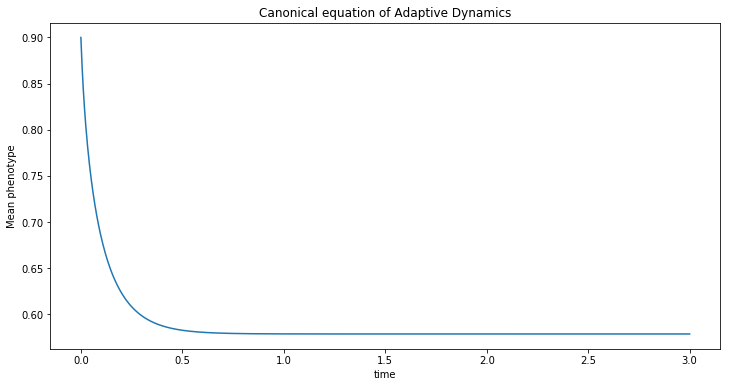

In [6]:
###### Let us simulate a trajectory ######
# We set the initial conditions.
u0 = 0.9

# And the time on which we want to integrate. 
t = np.linspace(0,3, 1000)

# Now we perform the numerical integration of the ODE `model`, with initial conditions `s0` over `t`
trajectory_strong = scipy.integrate.odeint(model, u0, t)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(t,trajectory_strong)
ax.set(title='Canonical equation of Adaptive Dynamics',
              xlabel='time',
              ylabel='Mean phenotype');

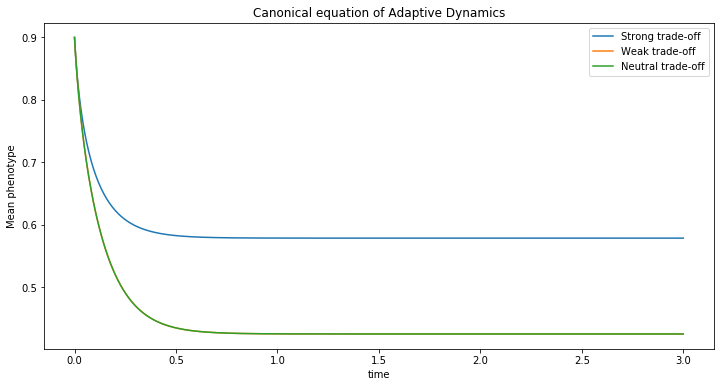

In [7]:
u0 =0.9
t = np.linspace(0,3, 1000)

model = partial(canonical_equation,
                n=partial(n_star, **p_strong),
                mu=mu, sigma=sigma,
                fitness_gradient=partial(fitness_gradient,
                                         inv_fitness=partial(invasion_fitness,**p_strong)))
traj_strong = scipy.integrate.odeint(model, u0, t)

model_wk = partial(canonical_equation,
                n=partial(n_star, **p_weak),
                mu=mu, sigma=sigma,
                fitness_gradient=partial(fitness_gradient,
                                         inv_fitness=partial(invasion_fitness,**p_weak)))
traj_weak = scipy.integrate.odeint(model_wk, u0, t)

model_n = partial(canonical_equation,
                  n=partial(n_star, **p_neutral),
                  mu=mu, sigma=sigma,
                  fitness_gradient=partial(fitness_gradient,
                                         inv_fitness=partial(invasion_fitness,**p_neutral)))
traj_n = scipy.integrate.odeint(model_wk, u0, t)

fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(t,traj_strong, label='Strong trade-off')
ax.plot(t,traj_weak, label='Weak trade-off')
ax.plot(t,traj_n, label='Neutral trade-off')
ax.legend()
ax.set(title='Canonical equation of Adaptive Dynamics',
              xlabel='time',
              ylabel='Mean phenotype');

# Appendix ~ Ecological simulations

Now that we are on the topic of numerical integration of ODE, we can have a look at the ecological dynamics of our system. 

In [8]:
# We define the ODE
def popdyn(x,t,u,a1,a2,b1,b2,d1,d2,K1,K2,mu):
    """Time derivative population dynamics model."""
    N,f1,f2 = x
    return np.array([(beta(u, f1, f2, a1, b1, a2, b2) - mu)*N,
                     d1*(K1-f1) - N*f1*A(u,a1,b1)*u,
                     d2*(K2-f2) - N*f2*A(u,a2,b2)*(1-u)])

def popdynElim(N,t,u,a1,a2,b1,b2,d1,d2,K1,K2,mu):
    """Time derivative population dynamics model with QSS on F1 and F2."""
    return N*growth_rate(N, 0, u, 0, a1, a2, b1, b2, K1, K2, d1, d2, mu)

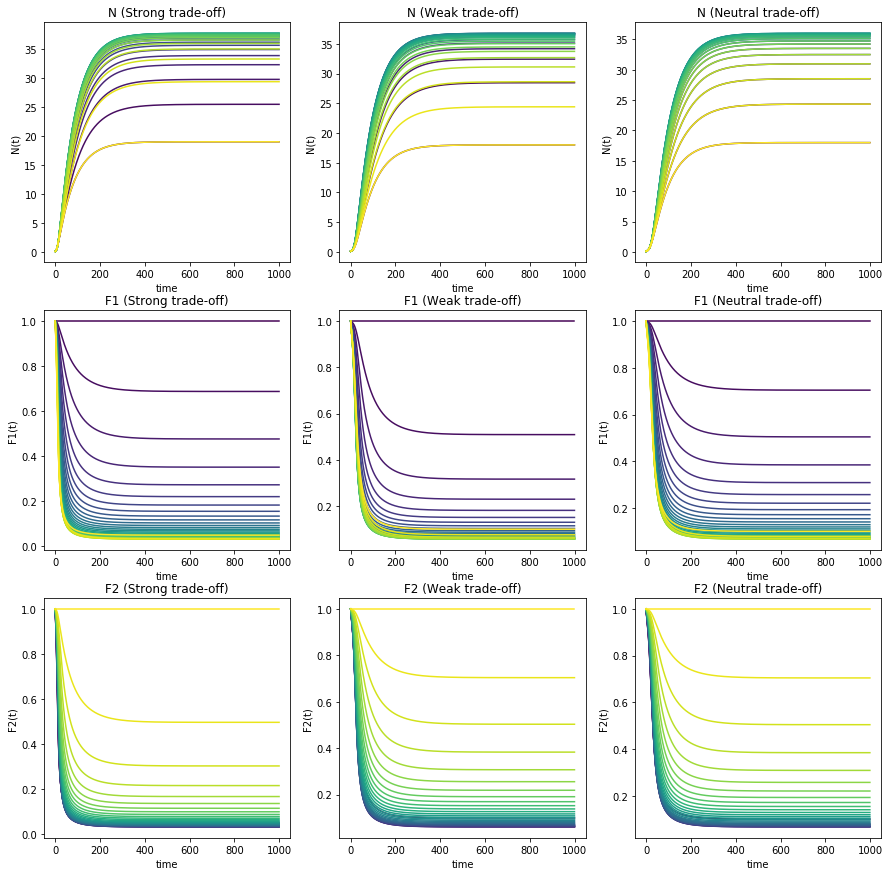

In [9]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
time = np.linspace(0,150,1000)
for i,(name,p) in enumerate((['Strong',p_strong],['Weak',p_weak],['Neutral',p_neutral])):
    for u in np.linspace(0,1,30):
        traj = scipy.integrate.odeint(partial(popdyn, u=u, **p),
                                              y0=[0.1,1,1],
                                              t=time)
        for j,(color,variable) in enumerate((('r','N'),('g','F1'),('b','F2'))):
            
            ax[j,i].plot(traj[:,j], c=matplotlib.cm.viridis(u))
            ax[j,i].set(title='{1} ({0} trade-off)'.format(name, variable),
                        xlabel='time', ylabel=variable+'(t)')

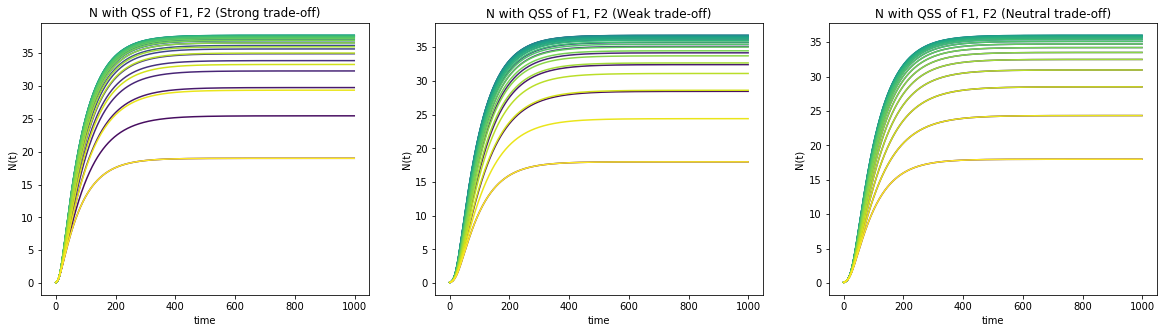

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,5),)
time = np.linspace(0,150,1000)
for i,(name,p) in enumerate((['Strong',p_strong],['Weak',p_weak],['Neutral',p_neutral])):
    for u in np.linspace(0,1,30):
        traj = scipy.integrate.odeint(partial(popdynElim, u=u, **p),
                                              y0=0.1,
                                              t=time)
        ax[i].plot(traj, c=matplotlib.cm.viridis(u))
        ax[i].set(title='N with QSS of F1, F2 ({0} trade-off)'.format(name),
                 xlabel='time', ylabel="N(t)")

Note that the QSS approximation does not seem to impact much the dynamics of the predator. As an exercise you can try to compute the error numerically. 